In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Construct the full path to the directory containing the package
project_path = '/workspace/apolune'

# Add the directory to sys.path
sys.path.append(project_path)

import numpy as np
import pickle
from copy import deepcopy
from scipy.integrate import odeint
import dynamics.crtbp_dynamics as crtbp
import dynamics.bcrfbp_dynamics_SE as bcrfbp_se
import frames.crtbp_transformations as crtbp_frame
import dynamics_coeff.dynamics_general_jit as dyn_coeff
import propagation.propagator as propagation
import cvxpy as cvx
import matplotlib.pyplot as plt
import spiceypy as spice
import init.load_kernels as krn
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
import time as tm
import scp_core
import dynamics_coeff.homotopy as homotopy
import scp_solve

In [2]:
%cd ../

/workspace/apolune


/opt/conda/envs/cppad_py_env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
def initial_guess(auxdata):
    n_x = auxdata['problem']['n_x']
    n_u = auxdata['problem']['n_u']
    n_man = auxdata['param']['n_man']
    
    time = auxdata['param']['time_vec']
    x0 = auxdata['param']['x0']
    
    
    if auxdata['problem']['free_tf'] == 1:
        tf = auxdata['param']['tf']
        time = time * tf
        p_guess = np.array([tf])
    else:
        p_guess = np.empty(0)
    
    u_guess = np.zeros((n_man, n_u))
    if auxdata['guess_model'] == 1:
        x_guess = propagation.propagate(crtbp.dynamics, x0, u_guess, p_guess, time, auxdata)
    elif auxdata['guess_model'] == 2:
        x_guess = propagation.propagate(bcrfbp_se.dynamics, x0, u_guess, p_guess, time, auxdata)
    elif auxdata['guess_model'] == 3:
        x_guess = propagation.propagate(dyn_coeff.dynamics, x0, u_guess, p_guess, time, auxdata)
    

    return x_guess, u_guess, p_guess



In [4]:
mu_earth_moon = 1.21506683e-2
#mu = mu_earth_moon
#LU = 3.84405000e5 # km
#TU = 4.34811305 # days
#VU = 1.02323281 # km/s

# crtbp
data = np.load('guess_generation/threebody_guesses_3.000645.npy', allow_pickle=True)
index = 0
LU = 1.495978706136889e+08 # 1 AU
mu = 3.003480593992993e-06 # Sun-Earth

# bcrfbp
mu_sun = 3.28900541e5 # adim
a_sun = 3.88811143e2 # adim
om_sun = -9.25195985e-1
sun_angle_t0 = 0.0

moon_earth_orbit_seconds = 2360591.78 # [s]
w_m = 2*np.pi/moon_earth_orbit_seconds # Angular velocity of the Moon about the Earth [-]

# rnbp_rpf
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

observer_id = 0

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 

id_primary = id_sun[0]
id_secondary = id_ear[0]

id_bodies = np.array([id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]])
naif_id_bodies = np.array([id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]])
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

MU = mu_bodies[id_primary] + mu_bodies[id_secondary]

TU = np.sqrt(LU**3 / MU)
VU = LU / TU # [km/s]

# epoch_t0 = spice.str2et('23 September 2022 00:00:00 TDB')
#epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
epoch_t0 = data[index]['start_epoch'] # Such that the moon is at the position of xf at tf
reference_frame = "j2000"
reference_frame_encoded = rnbp_utils.frame_encoder("J2000")
mu_p = mu_bodies[id_primary]
mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]
naif_id_s = naif_id_bodies[id_secondary]

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0
tau_f = 100.0
t0 = 0.0
n_points = 5000
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)


In [5]:
n_x = 6
n_u = 3
N = 200
Ns = N - 1

# 0: fixed final time, 1: free final time
# NOTE: i only implemented the case for free_tf = 0 so far
free_tf = 0

#model = 1 # crtbp
#model = 2 # bcrfbp
#model = 3 # rnbp_rpf
model = 4 # rnbp_rpf with fft, interpolation, and homotopy

if model == 4: 
    # Define parameters for approximation methods
    n_components_fft = 100 # not used for now since not removing high frequency components
    num_segments_piecewise = 20
    polynomial_degree = 3
    
    # Select homotopy method and extrapolation point
    sel_homotopy = 1 # 1: FFT ; 2: Piecewise ; 3: Polynomial
    if sel_homotopy == 1:
        homotopy_param = n_components_fft
    elif sel_homotopy == 2:
        homotopy_param = num_segments_piecewise
    elif sel_homotopy == 3:
        homotopy_param = polynomial_degree
    
    coeff_3bp_tmp, coeff_nbp_list, f_precomputed_list = homotopy.get_homotopy_coefficients(sel_homotopy, homotopy_param, tau_vec, t_vec, id_primary, id_secondary, mu_bodies, naif_id_bodies, observer_id, reference_frame_encoded, epoch_t0, use_jit=True)
    coeff_nbp = np.array((coeff_nbp_list), dtype=np.float64)
    f_precomputed = np.array((f_precomputed_list), dtype=np.float64)
    coeff_3bp = np.ascontiguousarray(coeff_3bp_tmp)



# node indices where maneuvers are applied; numpy array within [0, Ns]
# man_index = np.array([0, 30, 60, Ns])
#man_index = np.array([0, 50, Ns])
man_index = np.array([0, Ns])

# initial and final boundary conditions
# x0 = np.array([8.2338046140454002e-01, 0, 1.3886061447073000e-02, 0, 1.2947638542136800e-01, 0]) # adim
# xf = np.array([1.1194488032482977e+00, 2.3502976908423845e-13, -1.1371675247773910e-02, 2.2969820490104098e-13, 1.7876223257953414e-01, -2.7620527393024119e-13]) # adim
# t0 = 0.0
# tf = 6.9083604301186052e-01


# Working Example for Homotopy
#x0 = np.array([0.870183, -0.059444, 0, -0.010471, -0.175136, 0]) # adim
#xf = np.array([1.11559, -0.056398, 0, -0.008555, 0.157211, 0]) # adim
#t0 = 0.0
#tf = 12.34 / TU * 1.91 # time of flight

x0 = np.array(data[index]['x0'])
xf = data[index]['xf'] 
t0 = 0.0
tf = data[index]['tf']
#x0[3:6] *= 0.9998

# bounds for states, controls, and dv per maneuver
states_lower = -10.0 * np.ones(n_x)
states_upper = 10.0 * np.ones(n_x)
controls_lower = -10.0 * np.ones(n_u)
controls_upper = 10.0 * np.ones(n_u)
# dv_max = 0.5
dv_max = 0.05
# dv_max = 0.06

# n_p: number of free parameters in the optimization
# here: no free parameters
n_man = len(man_index)
n_p = 0

tf_ind = 0

# lower and upper bounds of the free variable vector p
p_lower = np.empty(0)
p_upper = np.empty(0)

# functions for dynamics and corresponding jacobian
jacobian_x_function = dyn_coeff.jacobian
dynamics_function = dyn_coeff.dynamics

# tolerances for the integrator
# we use different values for piecewise integration (from t_k to t_k+1) and full integration (from t0 to tf)
ode_atol_piecewise = 1e-10
ode_rtol_piecewise = 1e-10
ode_atol = 1e-12
ode_rtol = 1e-12

# discretized time vector
time = np.linspace(t0, tf, N)

# trust region parameters
tr_dict = {}
tr_dict['radius'] = 1
tr_dict['rho'] = 100.0
tr_dict['rho0'] = 0.01
tr_dict['rho1'] = 0.2
tr_dict['rho2'] = 0.85
tr_dict['alpha'] = 1.5
tr_dict['beta'] = 1.5
tr_dict['delta'] = 1.0
tr_dict['alpha_min'] = 1.01
tr_dict['alpha_max'] = 4.0
tr_dict['beta_min'] = 1.01
tr_dict['beta_max'] = 4.0
tr_dict['radius_min'] = 1e-7
tr_dict['radius_max'] = 500.0



In [6]:
# some internal definitions -> probably no need to change anything here for now

x_len = N*n_x
u_len = n_man*n_u
t_len = 0
p_len = n_p

xu_len = x_len + u_len
sol_len = xu_len + t_len + p_len
x_ind = slice(0, x_len) 
u_ind = slice(x_len, xu_len)
p_ind = slice(xu_len, xu_len+p_len)
tf_ind_sol = xu_len + tf_ind

stm_x_len = n_x*n_x
stm_t_len = n_x * free_tf
stm_const_len = n_x

V_len = n_x + stm_x_len + stm_t_len + stm_const_len
    
x_ind_stm = slice(0, n_x)
stm_x_ind = slice(n_x, stm_x_len+n_x)
stm_t_ind = slice(stm_x_len+n_x, stm_x_len+n_x+stm_t_len)
stm_const_ind = slice(stm_x_len+n_x+stm_t_len, stm_x_len+n_x+stm_t_len+stm_const_len)

V0 = np.zeros(V_len);
V0[stm_x_ind] = np.identity(n_x).flatten()
 
x_stm = np.zeros((N,n_x));
stm_x = np.zeros((Ns,n_x*n_x));
stm_t = np.zeros((Ns,stm_t_len));
stm_const = np.zeros((Ns,stm_const_len));

if free_tf == 1:
    time = np.linspace(0.0, 1.0, N)
else:
    time = np.linspace(t0, tf, N)

if man_index[0] == 0:
    man_index_defects = man_index[1:]
    n_man_defects = n_man - 1
else:
    man_index_defects = man_index
    n_man_defects = n_man


scaling_dict = {'LU': LU, 'VU': VU, 'TU': TU}
lengths_dict = {'x_len': x_len, 'u_len': u_len, 'xu_len': xu_len, 'p_len': p_len, 't_len': t_len, 'sol_len': sol_len, 'stm_x_len': stm_x_len, 'stm_t_len': stm_t_len, 'stm_const_len': stm_const_len, 'V_len': V_len}
indices_dict = {'x_ind': x_ind, 'u_ind': u_ind, 'p_ind': p_ind, 'tf_ind': tf_ind, 'tf_ind_sol': tf_ind_sol, 'x_ind_stm': x_ind_stm, 'stm_x_ind': stm_x_ind, 'stm_t_ind': stm_t_ind, 'stm_const_ind': stm_const_ind}
problem_dict = {'n_x': n_x, 'n_u': n_u, 'n_p': n_p, 'N': N, 'Ns': Ns, 'free_tf': free_tf, \
    'dynamics': dynamics_function, 'jacobian_x': jacobian_x_function}
param_dict = {'mu': mu, 't0': t0, 'tf': tf, 'x0': x0, 'xf': xf, 'time_vec': time, 'n_man': n_man, 'man_index': man_index, \
    'n_man_defects': n_man_defects, 'man_index_defects': man_index_defects, 'dv_max': dv_max, \
    'ode_atol': ode_atol, 'ode_rtol': ode_rtol, 'ode_atol_piecewise': ode_atol_piecewise, 'ode_rtol_piecewise': ode_rtol_piecewise}
boundaries_dict = {'states_lower': states_lower, 'states_upper': states_upper, 'controls_lower': controls_lower, 'controls_upper': controls_upper, \
    'p_lower': p_lower, 'p_upper': p_upper}
discretization_dict = {'V0': V0, 'x': x_stm, 'stm_x': stm_x, 'stm_t': stm_t, 'stm_const': stm_const}

auxdata = {'problem': problem_dict, 'lengths': lengths_dict, 'indices': indices_dict, 'param': param_dict, 'discretization': discretization_dict, 'boundaries': boundaries_dict, \
    'scaling': scaling_dict}

# for bcrfbp
auxdata["model"] = model
auxdata["mu_crtbp"] = mu
auxdata["mu_sun"] = mu_sun
auxdata["om_sun"] = om_sun
auxdata["sun_angle_t0"] = sun_angle_t0
auxdata["a_sun"] = a_sun

# for bcrfbp_se
auxdata['param']["mu_crtbp"] = mu
auxdata['param']["mu_s"] = mu_bodies[id_sun[0]] / (mu_bodies[id_ear[0]] + mu_bodies[id_moo[0]]) # 328900.55981024733
auxdata['param']["moon_state_start"] = data[index]['moon_state_start'] # Used to calculate theta0
auxdata['param']["a_s"] = a_sun
auxdata['param']["om_sun"] = om_sun
auxdata['param']["mu_earth_moon"] = mu_earth_moon

# for rnbp_rpf
auxdata["id_primary"] = id_primary
auxdata["id_secondary"] = id_secondary
auxdata["mu_bodies"] = mu_bodies
auxdata["naif_id_bodies"] = naif_id_bodies
auxdata["observer_id"] = observer_id
# auxdata["reference_frame"] = reference_frame # needed if no numba / jit is used
auxdata["reference_frame"] = reference_frame_encoded # needed for numba and jit
auxdata["epoch_t0"] = epoch_t0
auxdata["tau_vec"] = tau_vec
auxdata["t_vec"] = t_vec

#for homotopy
if model == 4:
    homot_param = 0 # Homotopy parameter (0 <= eps <= 1), would update this with a function in the future
    auxdata['coeff_3bp'] = coeff_3bp
    auxdata['coeff_nbp'] = coeff_nbp
    auxdata['f_precomputed'] = f_precomputed
    auxdata['homot_param'] = homot_param
    auxdata['sel_homotopy'] = sel_homotopy

# print("coeff_3bp.shape: ", coeff_3bp.shape)
# print("coeff_nbp.shape: ", coeff_nbp.shape)
# print("f_precomputed.shape: ", f_precomputed.shape)

# print("type coeff_3bp: ", type(coeff_3bp))
# print("type coeff_nbp: ", type(coeff_nbp))
# print("type f_precomputed: ", type(f_precomputed))

def saveFigure(figureName, plt, path, **kwargs):
    save_opt = kwargs.get("save_opt", "pdf")
    figFileName = path+figureName+ "." + save_opt  # Also png
    plt.savefig(figFileName, transparent=True, bbox_inches='tight', dpi=300, pad_inches=0.05)
    print(f"Figure saved as {figFileName}")

Figure saved as ./3bp_4bp_guesses.pdf


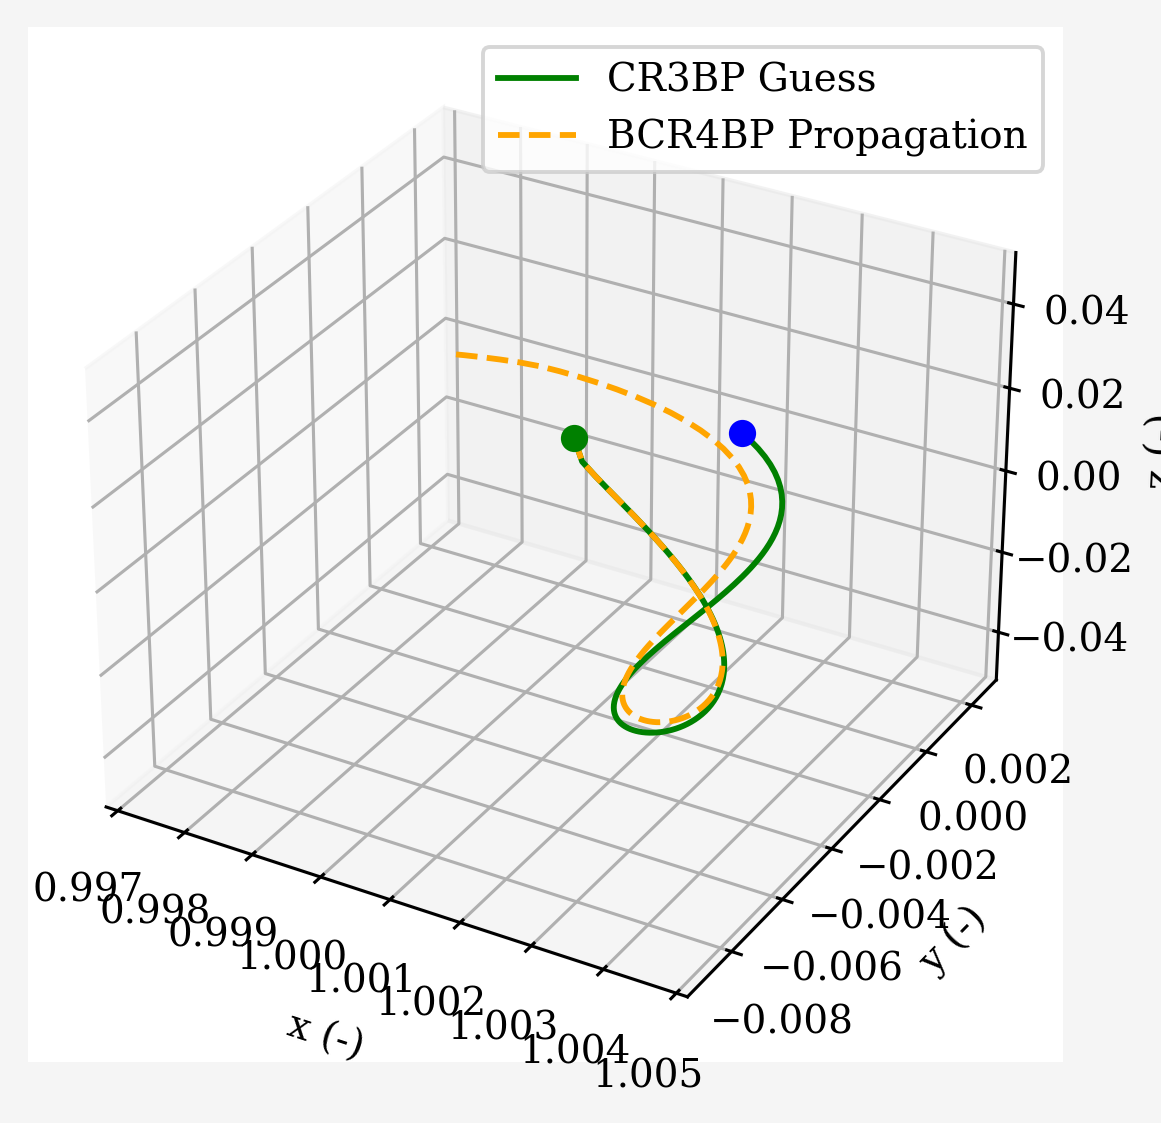

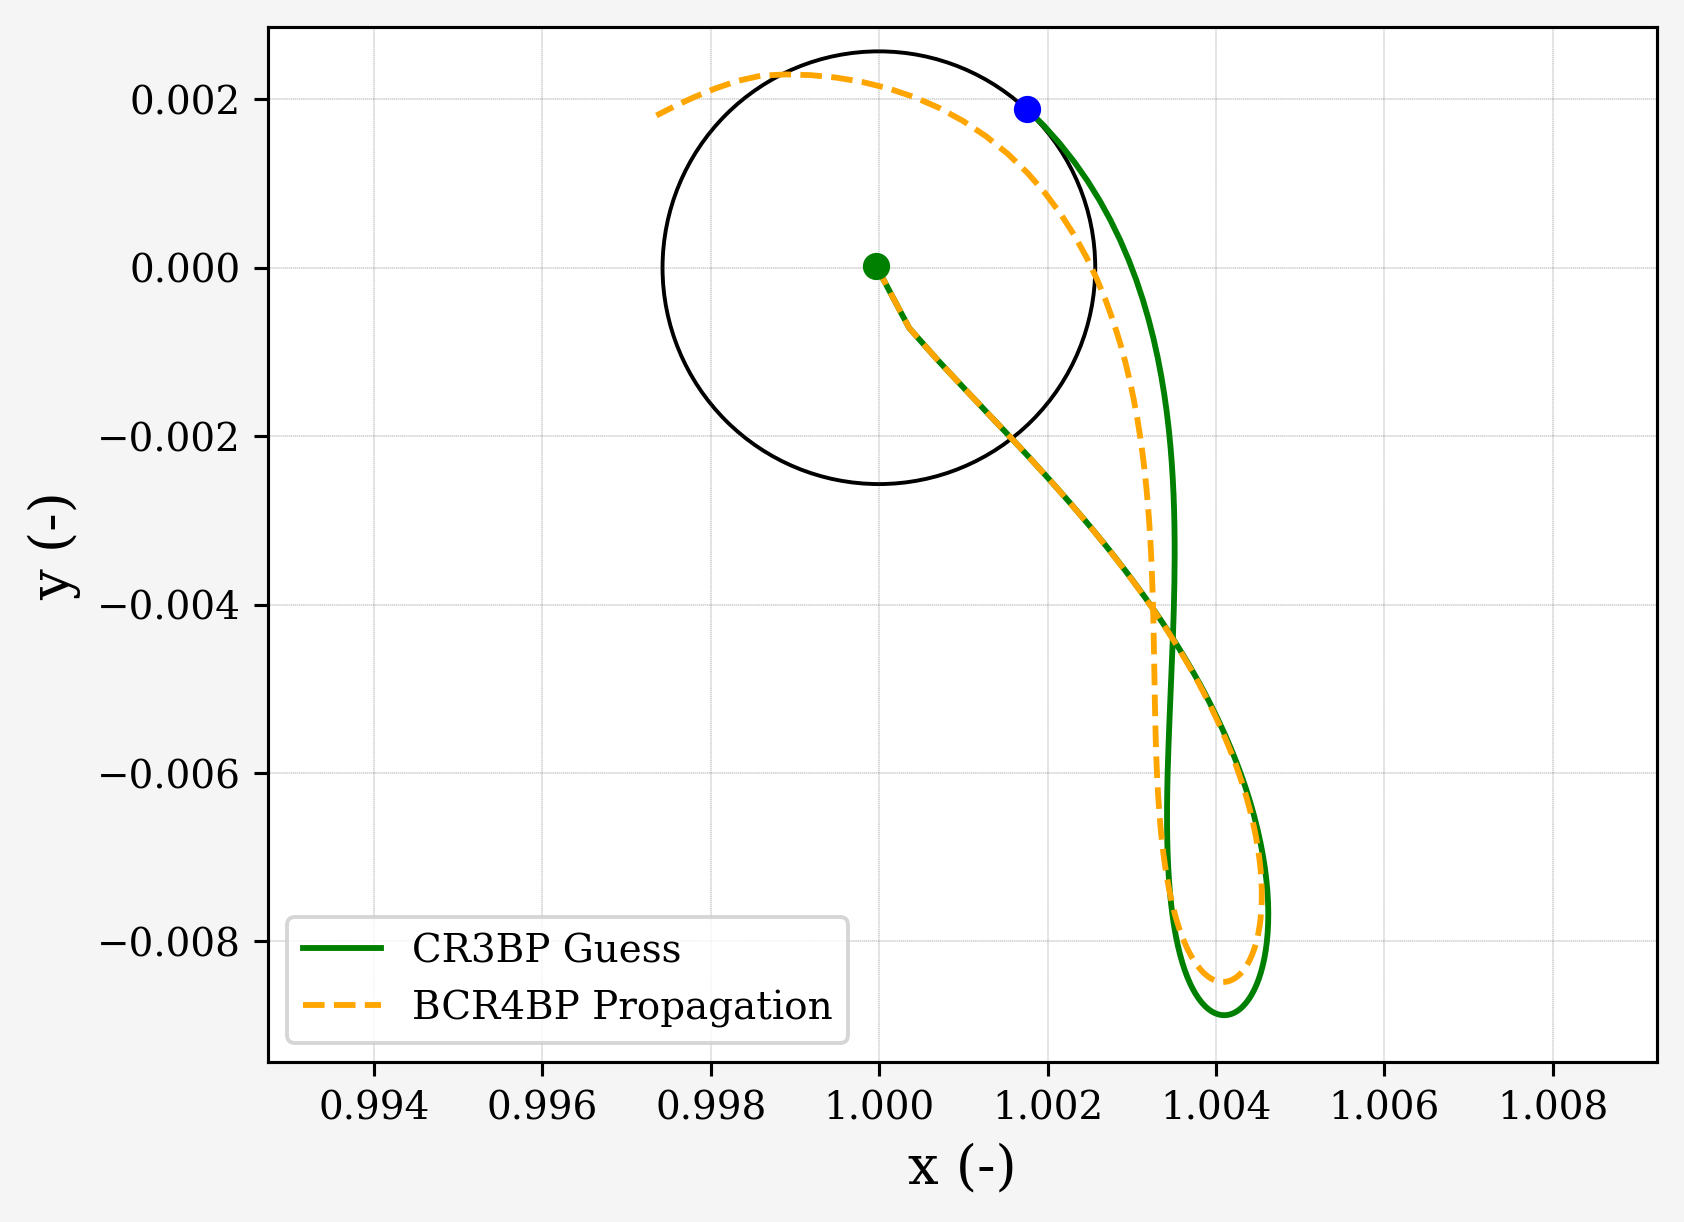

In [7]:
# generate initial guess 
auxdata['guess_model'] = 1
state_guess_3bp, control_guess, p_guess = initial_guess(auxdata)
auxdata['guess_model'] = 2
state_guess_4bp, control_guess, p_guess = initial_guess(auxdata)
auxdata['guess_model'] = 3
state_guess_rnbp, control_guess, p_guess = initial_guess(auxdata)

guess_dict = {}
guess_dict['state'] = state_guess_4bp
guess_dict['control'] = control_guess
guess_dict['p'] = p_guess
guess_dict['time'] = time

# Plotting 3D
plt.rc('font', family='serif')
plt.figure(dpi=280, facecolor='whitesmoke')
ax = plt.axes(projection ='3d')
ax.set_facecolor('white')
ax.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
ax.plot(state_guess_3bp[:,0], state_guess_3bp[:,1], state_guess_3bp[:,2], label='CR3BP Guess', color='green')
ax.plot(state_guess_4bp[:,0], state_guess_4bp[:,1], state_guess_4bp[:,2], label='BCR4BP Propagation', linestyle='--', color='orange')
#ax.plot(state_guess_rnbp[:,0], state_guess_rnbp[:,1], state_guess_rnbp[:,2], label='RNBP Guess', linestyle='-.')
ax.plot(xf[0], xf[1], xf[2], 'bo')
ax.plot(x0[0], x0[1], x0[2], 'go')
#ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
#ax.set_ylim([-5E+5 / LU, 5E+5 / LU])
ax.set_xlabel("x (-)")
ax.set_ylabel("y (-)")
ax.set_zlabel("z (-)")
ax.legend()
plt.legend()

# Plotting 2D
plt.figure(dpi=280, facecolor='whitesmoke')
ax = plt.axes()
circle = plt.Circle((1-mu, 0), 384400 / LU, color='k', fill=False)
ax.add_artist(circle)
ax.set_facecolor('white')
ax.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
ax.plot(state_guess_3bp[:,0], state_guess_3bp[:,1], label='CR3BP Guess', color='green')
ax.plot(state_guess_4bp[:,0], state_guess_4bp[:,1], label='BCR4BP Propagation', linestyle='--', color='orange')
#ax.plot(state_guess_rnbp[:,0], state_guess_rnbp[:,1], label='RNBP Guess', linestyle='-.')
ax.plot(xf[0], xf[1], 'bo')
ax.plot(x0[0], x0[1], 'go')
ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])
ax.set_xlabel("x (-)", fontsize=14)
ax.set_ylabel("y (-)", fontsize=14)
ax.axis('equal')

plt.legend()

saveFigure("3bp_4bp_guesses", plt, "./")

In [8]:
scp_data = {}

scp_data['verbose_solver'] = False

scp_data['feasibility_tol'] = 1e-7
scp_data['optimality_tol'] = 1e-3
scp_data['step_tol'] = 1e-8

scp_data['max_iterations'] = 1000
scp_data['factor_nonlin'] = 10.0
scp_data['factor_lin'] = 10.0

scp_data['objective_old'] = 1e-3

homotopic_param_step_size = 0.1
converged_flag = 0

# List to store solution data for each homotopic parameter value
solution_data_list = []

# basic code for homotopic approach
while converged_flag != 1:
    solution_data = scp_solve.solve(guess_dict, scp_data, tr_dict, auxdata)
    
    # Save the solution data for the current homotopic parameter value
    solution_data_list.append(deepcopy(solution_data))
    
    if solution_data['converged_flag'] == 1: # found an optimal solution -> increase homotopic parameter
        if(auxdata['homot_param'] >= 1):
            print("Reached solution in nbp")
            break
        auxdata['homot_param'] = np.min([auxdata['homot_param'] + homotopic_param_step_size, 1.0])
        
        guess_dict['state'] = deepcopy(solution_data['state'])
        guess_dict['control'] = deepcopy(solution_data['control'])
        guess_dict['p'] = deepcopy(solution_data['p'])
        guess_dict['time'] = deepcopy(solution_data['time'])
        scp_data['objective_old'] =  solution_data['objective_new'] # np.sum(guess_dict['control']**2, axis=1) # compute value of objective function
        
        # potentially update trust-region radius:
        # tr_dict['radius'] = 50.0 
    else: # failed to find an optimal solution -> reduce homotopic parameter and try again
        auxdata['homot_param'] -= homotopic_param_step_size / 2
        if auxdata['homot_param'] < 0: # if this is < 0 -> stop
            print("failed to obtain solution with homot_param = 0")
            break

with open('solutions.pkl', 'wb') as f:
    pickle.dump(solution_data_list, f)


obj_old: 0.001
obj_val: 3.8086607043533887e-06
homot_param: 0
predicted_decrease: 0.15754117256993042
Solution accepted.
iter            max_viol             dJ          c_lin         c_nlin       lin_cost    nonlin_cost              J             dX             TR
1            0.000869317       0.996191    4.97145e-11    4.97145e-11    1.57284e-08       0.102873    3.80866e-06     0.00172174              1
obj_old: 3.8086607043533887e-06
obj_val: 2.762632698636359e-09
homot_param: 0
predicted_decrease: 0.10287256438408873
Solution accepted.
Increasing radius to =  1.5
iter            max_viol             dJ          c_lin         c_nlin       lin_cost    nonlin_cost              J             dX             TR
2            2.86287e-06       0.999275    3.60481e-12    3.60481e-12    1.37866e-09    0.000494739    2.76263e-09    0.000421912            1.5
obj_old: 2.762632698636359e-09
obj_val: 1.6155438298977853e-10
homot_param: 0
predicted_decrease: 0.0004947383956107169
Solution accep

SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

control_cvx.value:  [[-7.87968758e-04  5.76727965e-04 -1.17588597e-04]
 [ 6.96766790e-06  3.05714174e-04  2.69761333e-07]]
dv's:  [0.00098353 0.00030579]
total dv:  0.0012893265949466021
xf_sol:  [ 1.00173983e+00  1.87508430e-03  2.28743879e-12 -3.01879948e-02
  2.80587885e-02  2.24211037e-15]
xf_guess:  [1.001739828200876, 0.001875084295532662, 0, -0.030187994750291394, 0.028058788490847444, 0]
difference [ 2.06501483e-14 -1.19422267e-13  2.28743879e-12  1.45716772e-16
  7.49400542e-16  2.24211037e-15]


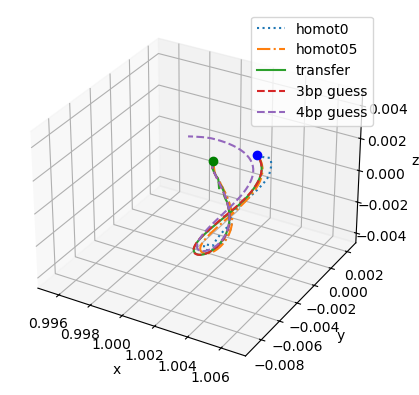

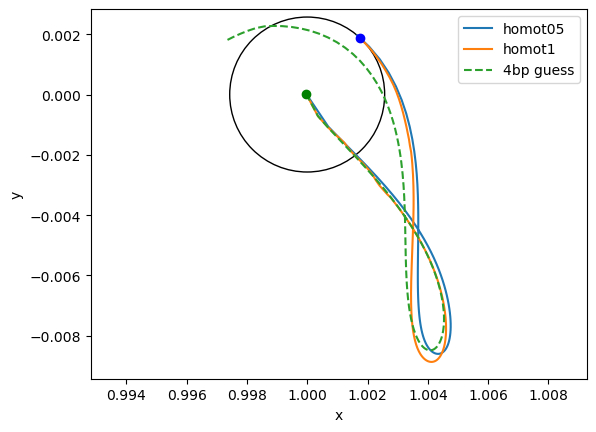

In [ ]:
state_sol = solution_data['state']
np.save('homot1.npy', state_sol)
control_sol = solution_data['control']
dv_array = np.linalg.norm(control_sol, axis=1)
print("control_cvx.value: ", control_sol)
print("dv's: ", dv_array)
print("total dv: ", np.sum(dv_array))

print("xf_sol: ", state_sol[-1])
print("xf_guess: ", xf)
print(f'difference {state_sol[-1] - xf}')

np.save('solution_state', state_sol)
np.save('guess_state', state_guess_4bp)

plt.figure()
ax = plt.axes(projection ='3d')
state_sol_homot0 = np.load('homot0.npy')
state_sol_homot05 = np.load('homot05.npy')

ax.plot(state_sol_homot0[:,0], state_sol_homot0[:,1], state_sol_homot0[:,2], label='homot0', linestyle='dotted')
ax.plot(state_sol_homot05[:,0], state_sol_homot05[:,1], state_sol_homot05[:,2], label='homot05', linestyle='dashdot')
ax.plot(state_sol[:,0], state_sol[:,1], state_sol[:,2], label='transfer')
ax.plot(state_guess_3bp[:,0], state_guess_3bp[:,1], state_guess_3bp[:,2], label='3bp guess', linestyle='dashed')
ax.plot(state_guess_4bp[:,0], state_guess_4bp[:,1], state_guess_4bp[:,2], label='4bp guess', linestyle='dashed')
ax.plot(xf[0], xf[1], xf[2], 'bo')
ax.plot(x0[0], x0[1], x0[2], 'go')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.axis('equal')
plt.legend()

fig, ax = plt.subplots()
circle = plt.Circle((1-mu, 0), 384400 / LU, color='k', fill=False)
ax.add_artist(circle)

#ax.plot(state_sol_homot0[:,0], state_sol_homot0[:,1], label='homot0')
ax.plot(state_sol_homot05[:,0], state_sol_homot05[:,1], label='homot05')
ax.plot(state_sol[:,0], state_sol[:,1], label='homot1')
#ax.plot(state_guess_3bp[:,0], state_guess_3bp[:,1], label='3bp guess', linestyle='dashed')
ax.plot(state_guess_4bp[:,0], state_guess_4bp[:,1], label='4bp guess', linestyle='dashed')
ax.plot(xf[0], xf[1], 'bo')
ax.plot(x0[0], x0[1], 'go')
ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')

plt.legend()
plt.show()




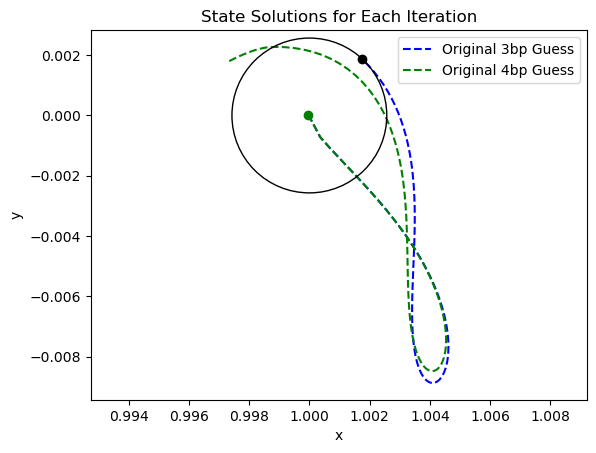

In [24]:
# Load the states from the states.pkl file
with open(os.path.join(project_path, 'iterations.pkl'), 'rb') as f:
    scp_states = pickle.load(f)

scp_states = scp_states[0:-1]

# Number of iterations
num_iterations = len(scp_states)

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_iterations) for i in range(num_iterations)]

# Plot the states for each iteration
plt.figure()
for i, state in enumerate(scp_states):
    plt.plot(state[:, 0], state[:, 1], color=colors[i], label=f'Iteration {i+1}' if i == num_iterations - 1 else "", zorder=i)

# Plot the original guess state with a different color
plt.plot(state_guess_3bp[:, 0], state_guess_3bp[:, 1], color='blue', linestyle='dashed', label='Original 3bp Guess', zorder=num_iterations)
plt.plot(state_guess_4bp[:, 0], state_guess_4bp[:, 1], color='green', linestyle='dashed', label='Original 4bp Guess', zorder=num_iterations)

circle = plt.Circle((1-mu, 0), 384400 / LU, color='k', fill=False)
plt.plot(x0[0], x0[1], 'go')
plt.plot(xf[0], xf[1], 'ko', zorder = num_iterations + 1)
plt.gca().add_artist(circle)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('State Solutions for Each Iteration')
plt.show()

Figure saved as ./3bp_4bp_guess_moon.pdf
Figure saved as ./homotopy_lunar_transfer.pdf
Figure saved as ./homotopy_lunar_transfer_yz.pdf


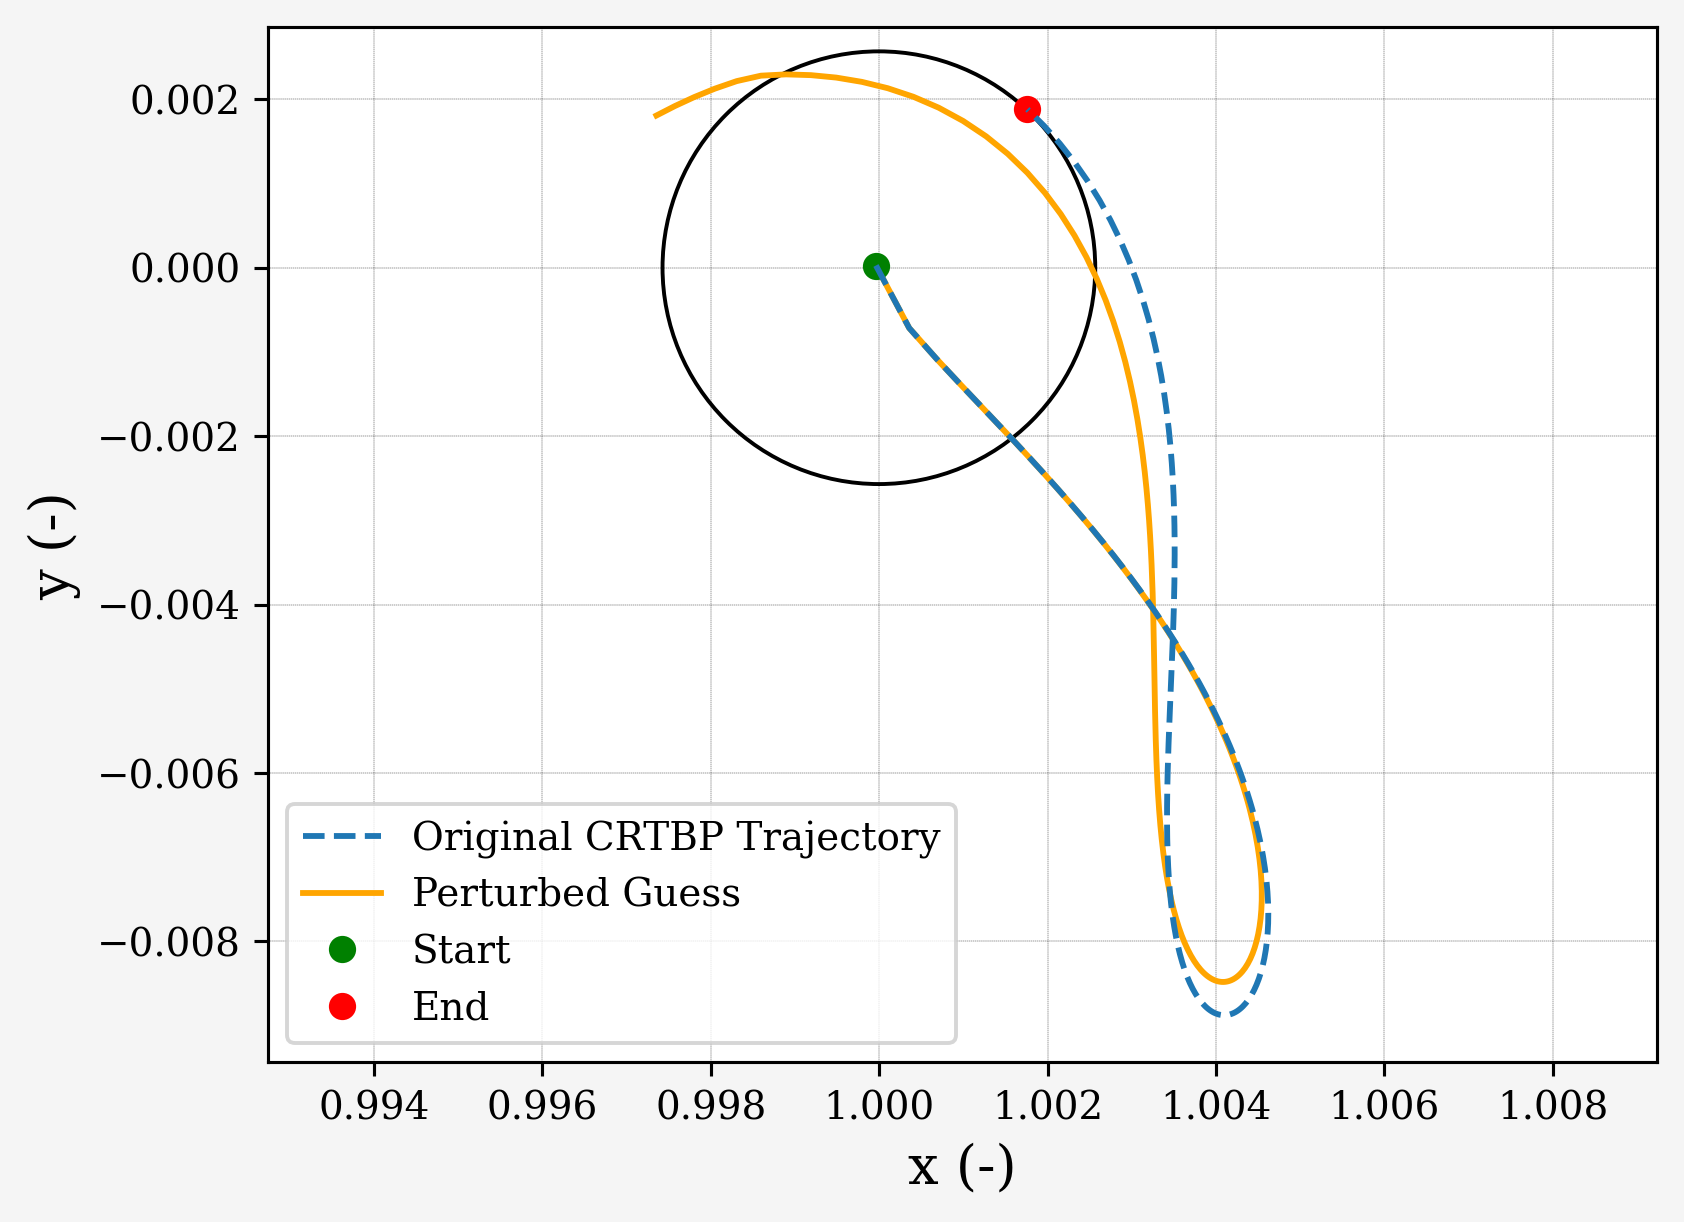

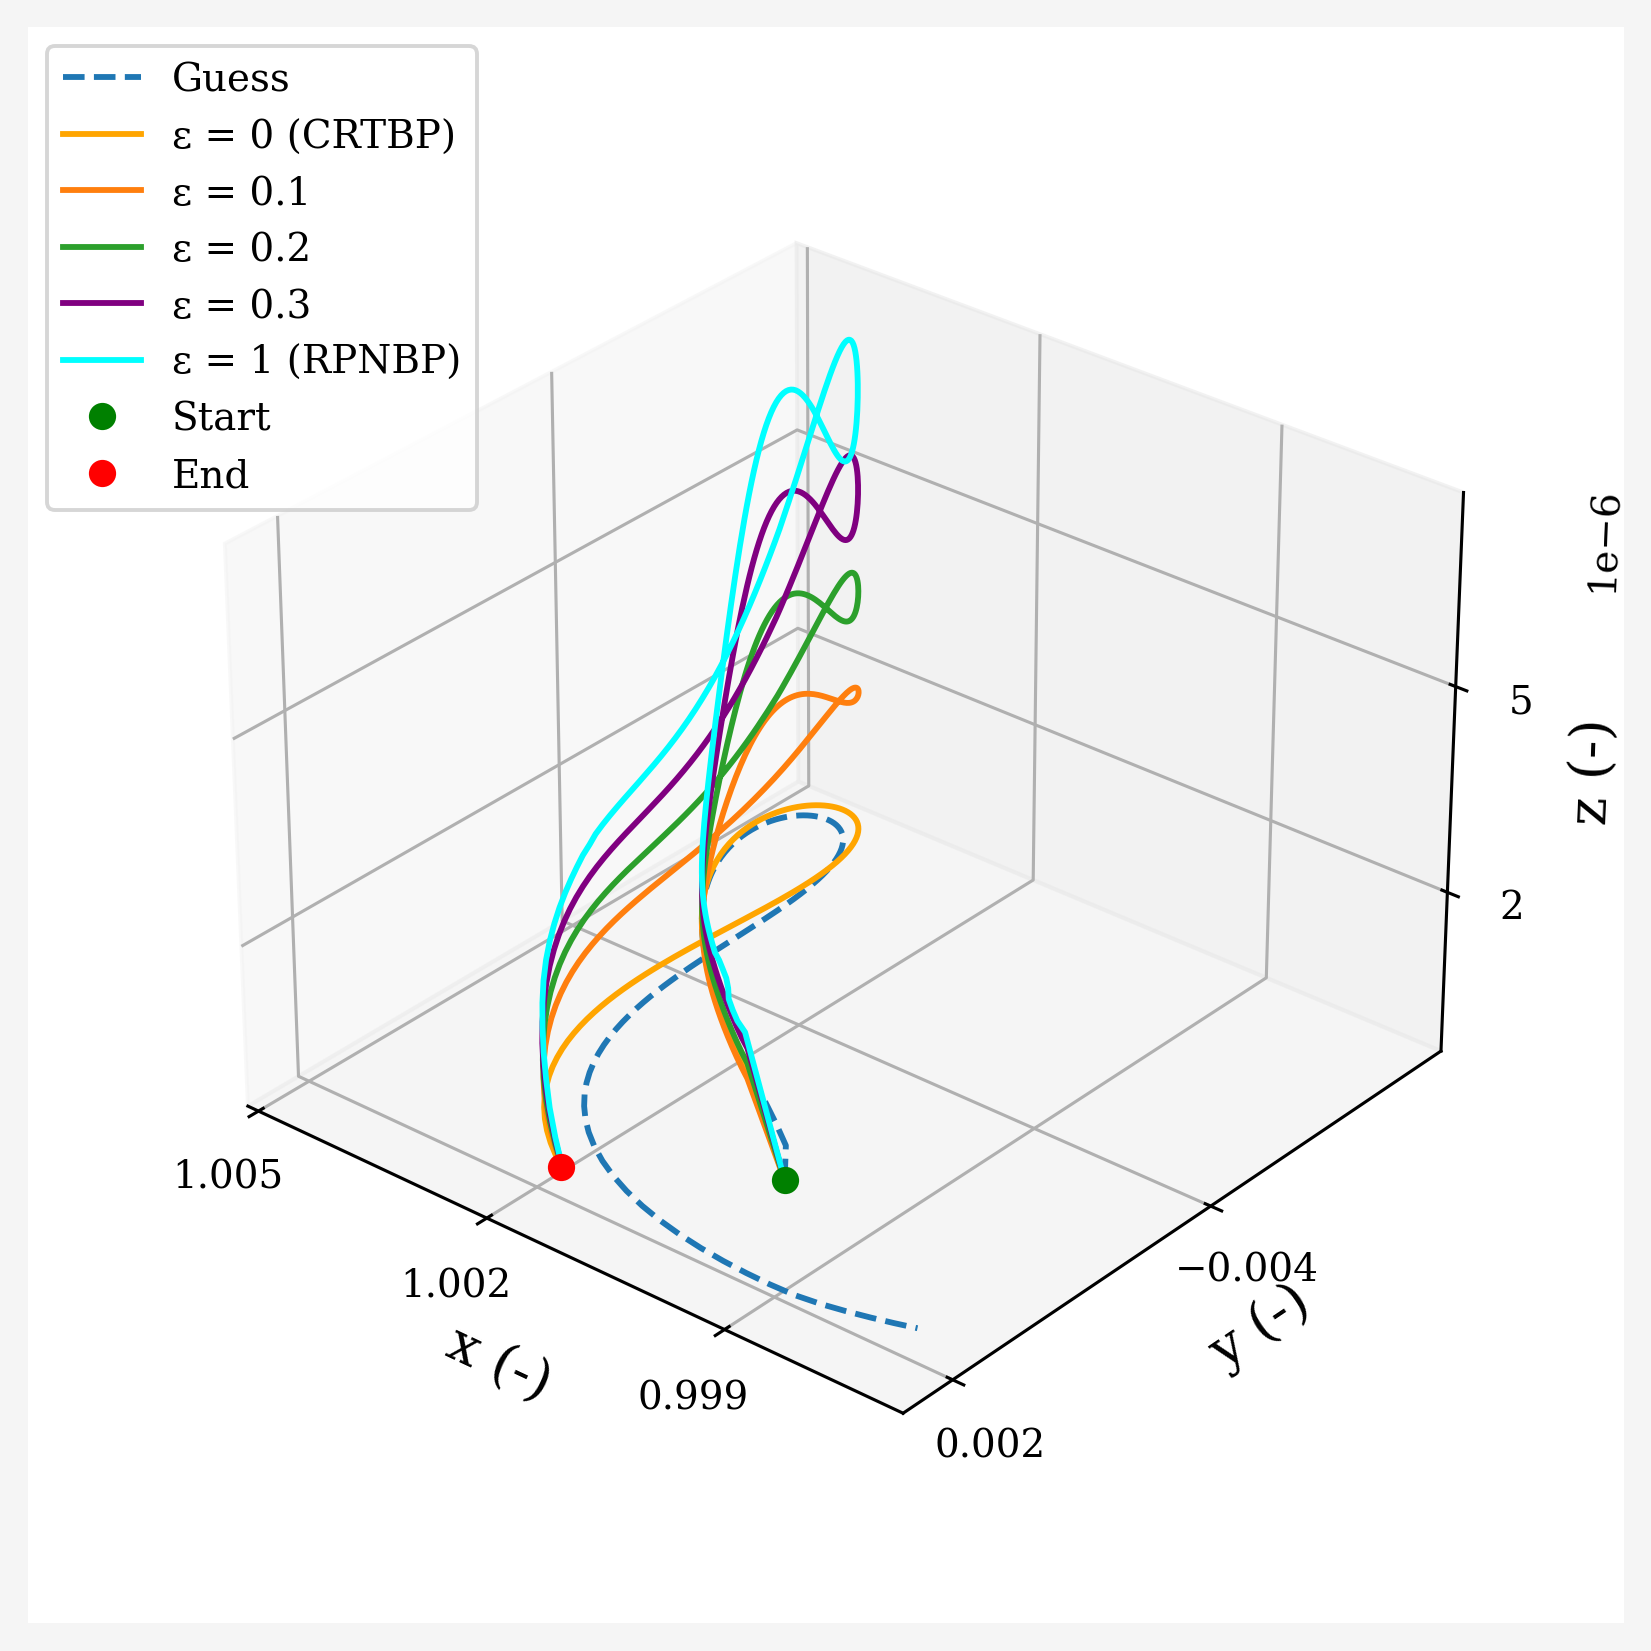

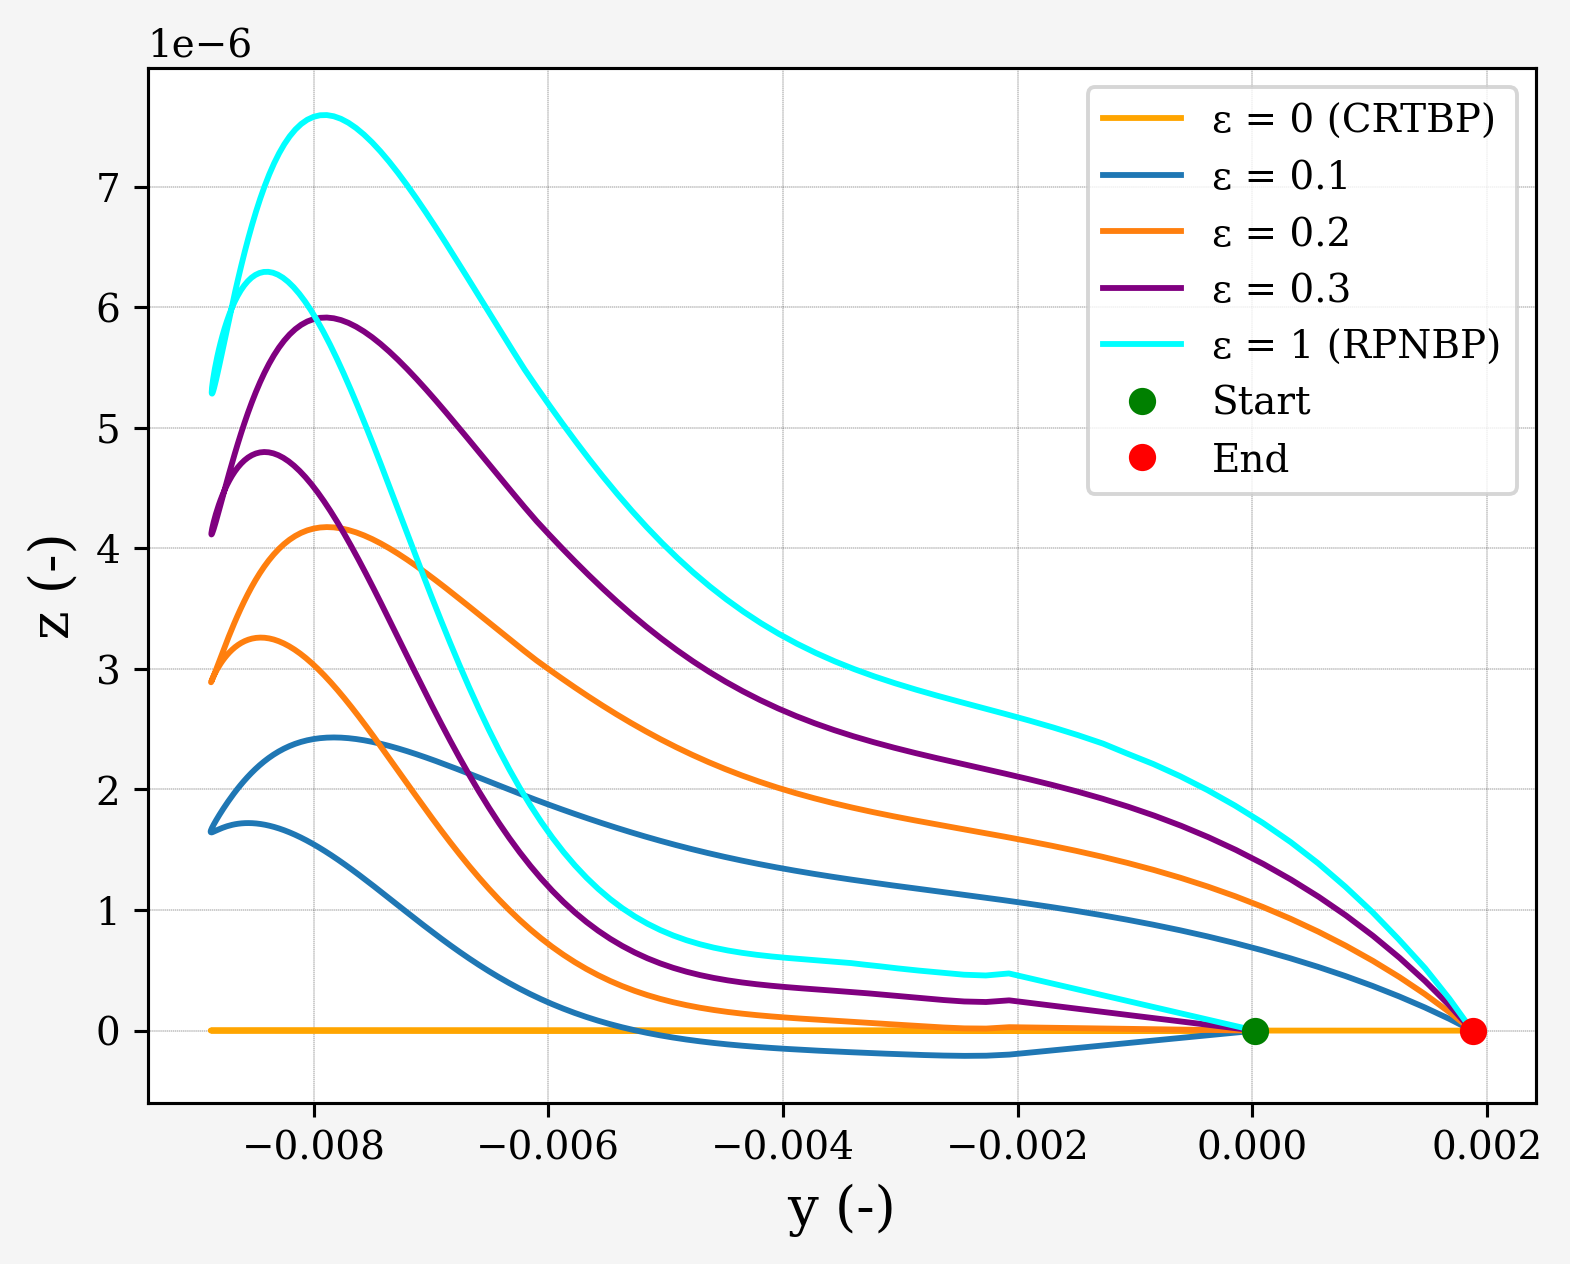

In [52]:
with open(os.path.join(project_path, 'solutions645ind0.pkl'), 'rb') as f:
    sol_states = pickle.load(f)

for sol in sol_states:
    sol['state'] = np.delete(sol['state'], np.s_[1:6], axis=0)
    #sol['state'] = np.delete(sol['state'], [4, 5], axis=0)

cmap = plt.get_cmap('viridis')
colors = [cmap(i / 11) for i in range(11)]

# 2D Plot
plt.figure(dpi=280, facecolor='whitesmoke')
ax = plt.axes()
ax.grid(linestyle="--", linewidth=0.1, color='.01', zorder=-10)
#for i, sol in enumerate(sol_states):
#    state = sol['state']
#    plt.plot(state[:, 0], state[:, 1], color=colors[i])

plt.plot(state_guess_3bp[:, 0], state_guess_3bp[:, 1], linestyle='dashed', label='Original CRTBP Trajectory', zorder = 3)
plt.plot(state_guess_4bp[:, 0], state_guess_4bp[:, 1], color='orange', label='Perturbed Guess')

circle = plt.Circle((1-mu, 0), 384400 / LU, color='k', fill=False)
plt.plot(x0[0], x0[1], 'go', label='Start')
plt.plot(xf[0], xf[1], 'ro', label='End')
#plt.plot(1-mu, 0, 'o', color='gray', label='Moon')
plt.gca().add_artist(circle)
plt.axis('equal')
plt.xlabel('x (-)', fontsize=14)
plt.ylabel('y (-)', fontsize=14)
plt.legend()

saveFigure("3bp_4bp_guess_moon", plt, "./")

# 3D Plot
fig = plt.figure(dpi=280, facecolor='whitesmoke', figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.grid(linestyle="--", linewidth=0.1, color='.01', zorder=-10)
#for i, sol in enumerate(sol_states):
#    state = sol['state']
#    time = 7
#    ax.plot(state[:time, 0], state[:time, 1], state[:time, 2], color=colors[i])
    

#ax.plot(state_guess_3bp[:, 0], state_guess_3bp[:, 1], state_guess_3bp[:, 2], color='blue', linestyle='dashed', label='Original 3bp Guess')
ax.plot(state_guess_4bp[:, 0], state_guess_4bp[:, 1], state_guess_4bp[:, 2], linestyle='dashed', label='Guess')

state_homot_0 = sol_states[0]['state']
ax.plot(state_homot_0[:, 0], state_homot_0[:, 1], state_homot_0[:, 2], label='ε = 0 (CRTBP)', color='orange')

state_homot_01 = sol_states[1]['state']
ax.plot(state_homot_01[:, 0], state_homot_01[:, 1], state_homot_01[:, 2], label='ε = 0.1',)

state_homot_02 = sol_states[2]['state']
ax.plot(state_homot_02[:, 0], state_homot_02[:, 1], state_homot_02[:, 2], label='ε = 0.2')

state_homot_03 = sol_states[3]['state']
ax.plot(state_homot_03[:, 0], state_homot_03[:, 1], state_homot_03[:, 2], label='ε = 0.3', color='purple')

state_homot_1 = sol_states[-1]['state']
ax.plot(state_homot_1[:, 0], state_homot_1[:, 1], state_homot_1[:, 2], label='ε = 1 (RPNBP)', color='cyan')

ax.view_init(elev=30, azim=130)

ax.plot([x0[0]], [x0[1]], [x0[2]], 'go', label='Start')
ax.set_xticks(ax.get_xticks()[::3])
ax.set_yticks(ax.get_yticks()[::3])
ax.set_zticks(ax.get_zticks()[::3])
ax.plot([xf[0]], [xf[1]], [xf[2]], 'ro', label='End')
ax.set_xlabel('x (-)', fontsize=14)
ax.set_ylabel('y (-)', fontsize=14)
ax.set_zlabel('z (-)', fontsize=14)
ax.legend(loc='upper left')
ax.set_box_aspect(None, zoom=0.84)
plt.tight_layout()
saveFigure("homotopy_lunar_transfer", plt, "./")

# 2D Plot in y-z plane
fig, ax = plt.subplots(dpi=280, facecolor='whitesmoke')
ax.grid(linestyle="--", linewidth=0.1, color='.01', zorder=-10)

ax.plot(state_homot_0[:, 1], state_homot_0[:, 2], label='ε = 0 (CRTBP)', color='orange')
ax.plot(state_homot_01[:, 1], state_homot_01[:, 2], label='ε = 0.1')
ax.plot(state_homot_02[:, 1], state_homot_02[:, 2], label='ε = 0.2')
ax.plot(state_homot_03[:, 1], state_homot_03[:, 2], label='ε = 0.3', color='purple')
ax.plot(state_homot_1[:, 1], state_homot_1[:, 2], label='ε = 1 (RPNBP)', color='cyan')

ax.plot([x0[1]], [x0[2]], 'go', label='Start')
ax.plot([xf[1]], [xf[2]], 'ro', label='End')

ax.set_xlabel('y (-)', fontsize=14)
ax.set_ylabel('z (-)', fontsize=14)
ax.legend()

saveFigure("homotopy_lunar_transfer_yz", plt, "./")

In [14]:
data = np.load('guess_generation/threebody_guesses_3.000645.npy', allow_pickle=True)
#print(spice.et2utc(data[0]['start_epoch'], "C", 0))
#print(spice.et2utc(data[0]['end_epoch'], "C", 0))
print(data[0]['tf'] * TU / (60*60*24))

with open(os.path.join(project_path, 'solutions645ind0.pkl'), 'rb') as f:
    sol_states = pickle.load(f)
print(sol_states[-1]['time'][-1]* TU / (60*60*24))
control_sol = sol_states[-1]['control']
dv_array = np.linalg.norm(control_sol, axis=1)
dv_total = np.sum(dv_array)
print(sol_states[-1]['control'][0])
print(control_sol)

79.19236773346724
79.07595557549274
[-0.00078797  0.00057673 -0.00011759]
[[-7.87968758e-04  5.76727965e-04 -1.17588597e-04]
 [ 6.96766790e-06  3.05714174e-04  2.69761333e-07]]


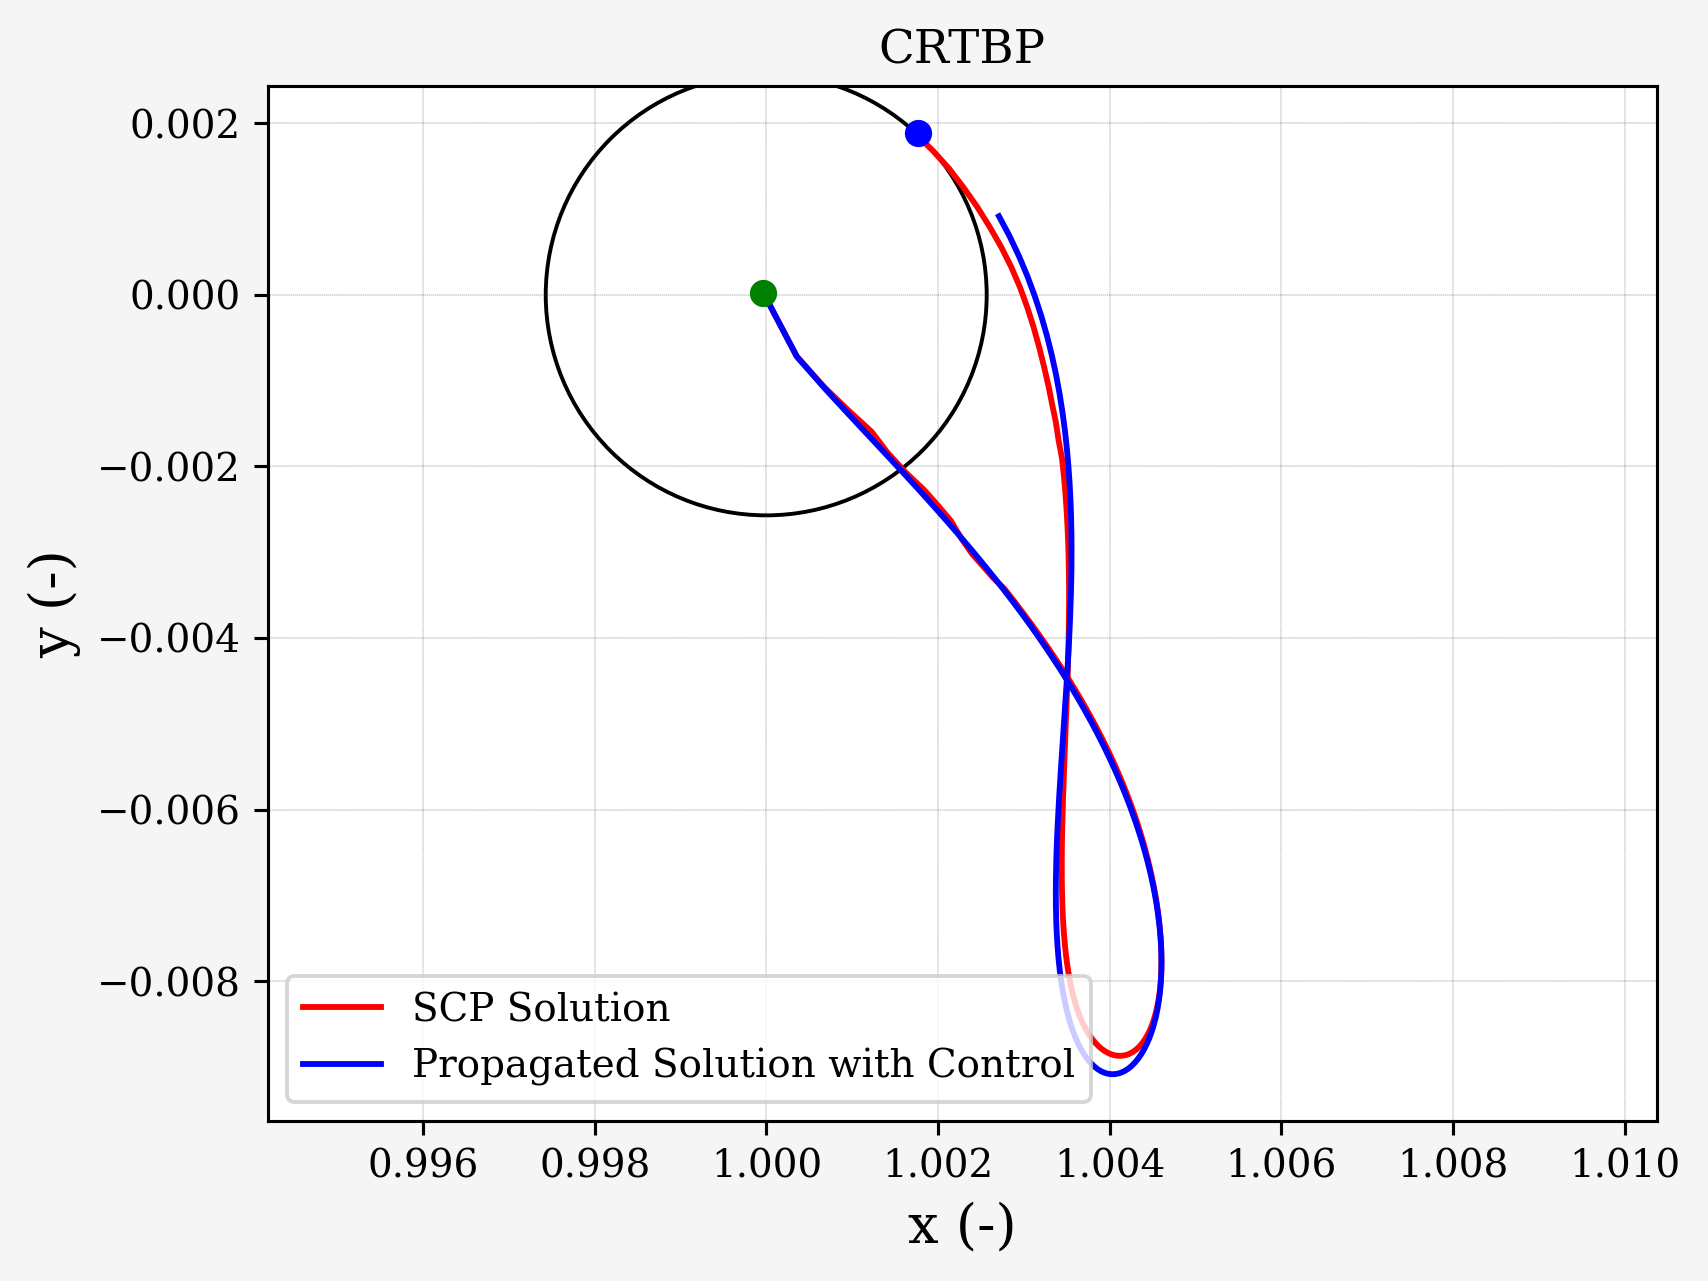

In [33]:
#time = sol_states[-1]['time']
time = np.linspace(t0, tf, N)
x0 = np.array(data[index]['x0'])
x0[3:6] += sol_states[-1]['control'][0]
p_guess = np.empty(0)

u_guess = np.zeros((n_man, n_u))
x_guess = propagation.propagate(crtbp.dynamics, x0, u_guess, p_guess, time, auxdata)

plt.figure(dpi=280, facecolor='whitesmoke')
ax = plt.axes()
circle = plt.Circle((1-mu, 0), 384400 / LU, color='k', fill=False)
ax.add_artist(circle)
ax.set_facecolor('white')
ax.grid(linestyle="--", linewidth=0.1, color='.25', zorder=-10)
ax.plot(sol_states[-1]['state'][:,0], sol_states[-1]['state'][:,1], label='SCP Solution', color='red')
ax.plot(x_guess[:,0], x_guess[:,1], label='Propagated Solution with Control', color='blue')
ax.plot(xf[0], xf[1], 'bo')
ax.plot(x0[0], x0[1], 'go')
plt.title('CRTBP')

ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])
ax.set_xlabel("x (-)", fontsize=14)
ax.set_ylabel("y (-)", fontsize=14)
ax.axis('equal')
plt.legend(loc='lower left')
plt.show()


